## Principal Component Analysis

As we discussed earlier, transforming data using unsupervised learning can have many motivations. The most common motivations are visualization, compressing the data, and finding a representation that is more informative for further processing.

One of the simplest and most widely used algorithms for all of these is *principal component analysis*.  Principal component analysis is a method that rotates the dataset in a way such that the rotated features are statistically uncorrelated. This rotation is often followed by selecting only a subset of the new features, according to how important they are for explaining the data. 

The following example illustrates the effect of PCA on a synthetic two-dimensional dataset.

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

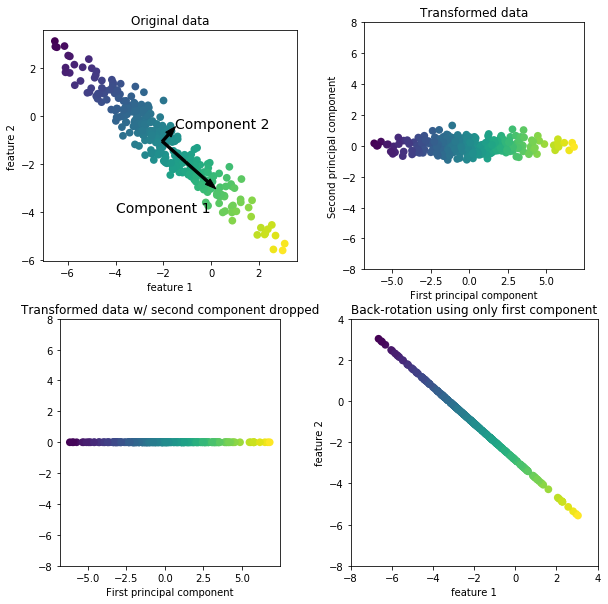

In [3]:
mglearn.plots.plot_pca_illustration()

The first plot (top left) shows the original data points, colored to distinguish among them. The algorithm proceeds by first finding the direction of maximum variance, labeled “Component 1.” This is the direction (or vector) in the data that contains most of the information, or in other words, the direction along which the features are most correlated with each other. Then, the algorithm finds the direction that contains the most information while being orthogonal (at a right angle) to the first direction. 

In two dimensions, there is only one possible orientation that is at a right angle, but in higher-dimensional spaces there would be (infinitely) many orthogonal directions. Although the two components are drawn as arrows, it doesn’t really matter where the head and the tail are; we could have drawn the first component from the center up to the top left instead of down to the bottom right. The directions found using this process are called *principal components*, as they are the main directions of variance in the data. In general, there are as many principal components as original features.

The second plot (top right) shows the same data, but now rotated so that the first principal component aligns with the x-axis and the second principal component aligns with the y-axis. Before the rotation, the mean was subtracted from the data, so that the transformed data is centered around zero. In the rotated representation found by PCA, the two axes are uncorrelated, meaning that the correlation matrix of the data in this representation is zero except for the diagonal.

We can use PCA for dimensionality reduction by retaining only some of the principal components. In this example, we might keep only the first principal component, as shown in the third panel (bottom left). This reduces the data from a two-dimensional dataset to a one-dimensional dataset. Note, however, that instead of keeping only one of the original features, we found the most interesting direction (top left to bottom right in the first panel) and kept this direction, the first principal component.

Finally, we can undo the rotation and add the mean back to the data. This will result in the data shown in the last panel. These points are in the original feature space, but we kept only the information contained in the first principal component. This transformation is sometimes used to remove noise effects from the data or visualize what part of the information is retained using the principal components.

### Applying PCA to the Cancer Dataset for Visualization

One of the most common applications of PCA is visualizing high-dimensional datasets. As we saw in Chapter 1, it is hard to create scatter plots of data that has more than two features. For the Iris dataset, we were able to create a pair plot that gave us a partial picture of the data by showing us all the possible combinations of two features. 

But if we want to look at the Breast Cancer dataset, even using a pair plot is tricky. The breast cancer dataset has 30 features, which would result in 30 * 29 / 2 = 435 scatter plots (for just the upper triangle)! We’d never be able to look at all these plots in detail, let alone try to understand them.

There is an even simpler visualization we can use, though—computing histograms of each of the features for the two classes, benign and malignant cancer.

In [4]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

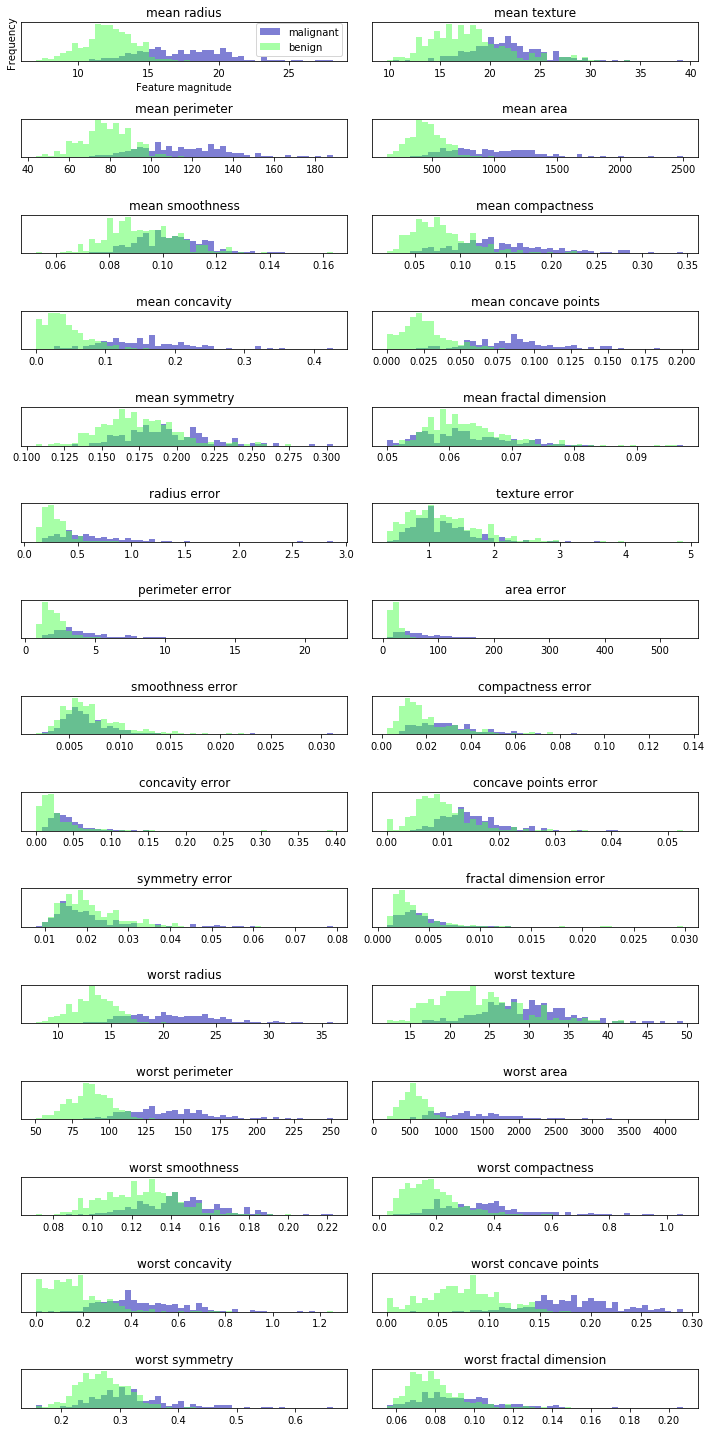

In [5]:
fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())

ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

Here we create a histogram for each of the features, counting how often a data point appears with a feature in a certain range (called a *bin*). Each plot overlays two histograms, one for all of the points in the benign class and one for all the points in the malignant class. This gives us some idea of how each feature is distributed across the two classes, and allows us to venture a guess as to which features are better at distinguishing malignant and benign samples. For example, the feature “smoothness error” seems quite uninformative, because the two histograms mostly overlap, while the feature “worst concave points” seems quite informative, because the histograms are quite disjoint.

However, this plot doesn’t show us anything about the interactions between variables and how these relate to the classes. Using PCA, we can capture the main interactions and get a slightly more complete picture. We can find the first two principal components, and visualize the data in this new two-dimensional space with a single scatter plot.

Before we apply PCA, we scale our data so that each feature has unit variance using *StandardScaler*.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

Learning the PCA transformation and applying it is as simple as applying a preprocessing transformation. 

We instantiate the PCA object, find the principal components by calling the fit method, and then apply the rotation and dimensionality reduction by calling transform. By default, PCA only rotates (and shifts) the data, but keeps all principal components. To reduce the dimensionality of the data, we need to specify how many components we want to keep when creating the PCA object.

In [7]:
from sklearn.decomposition import PCA

# Keep the first two principal components of the data
pca = PCA(n_components=2)

# Fit PCA model to breast cancer data
pca.fit(X_scaled)

# Transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


We can now plot the first two principal components.

Text(0, 0.5, 'Second principal component')

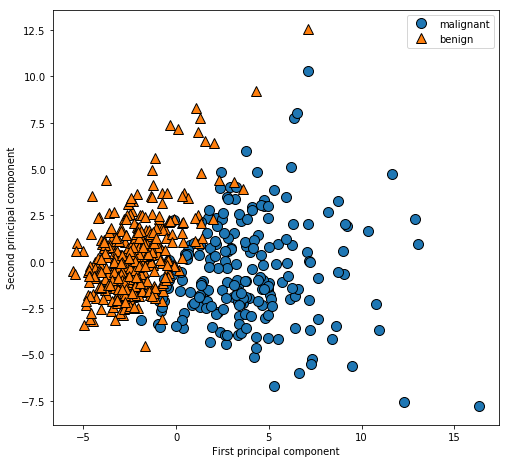

In [8]:
# Plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)

plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

It is important to note that PCA is an unsupervised method, and does not use any class information when finding the rotation. It simply looks at the correlations in the data. 

For the scatter plot shown here, we plotted the first principal component against the second principal component, and then used the class information to color the points. You can see that the two classes separate quite well in this two-dimensional space. This leads us to believe that even a linear classifier (that would learn a line in this space) could do a reasonably good job at distinguishing the two classes. We can also see that the malignant points are more spread out than the benign points—something that we could already see a bit from the histograms.

A downside of PCA is that the two axes in the plot are often not very easy to interpret. The principal components correspond to directions in the original data, so they are combinations of the original features. However, these combinations are usually very complex, as we’ll see shortly. The principal components themselves are stored in the *components_* attribute of the PCA object during fitting.

In [9]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


Each row in *components_* corresponds to one principal component, and they are sorted by their importance (the first principal component comes first, etc.). The columns correspond to the original features attribute of the PCA in this example, “mean radius,” “mean texture,” and so on. Let’s have a look at the content of *components_*.

In [10]:
print("PCA components:\n{}".format(pca.components_))

PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


We can also visualize the coefficients using a heat map, which might be easier to understand.

Text(0, 0.5, 'Principal components')

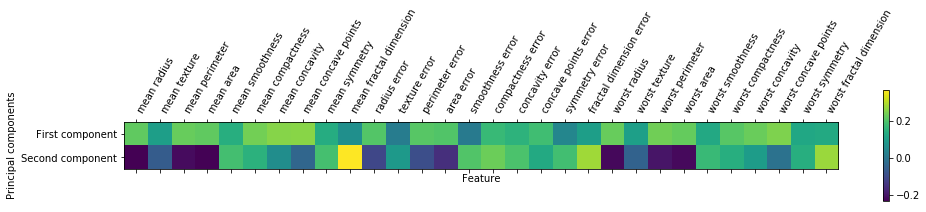

In [11]:
plt.matshow(pca.components_, cmap='viridis')

plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

You can see that in the first component, all features have the same sign (it’s positive, but as we mentioned earlier, it doesn’t matter which direction the arrow points in). That means that there is a general correlation between all features. As one measurement is high, the others are likely to be high as well. The second component has mixed signs, and both of the components involve all of the 30 features. This mixing of all features is what makes explaining the axes so tricky.

### Eigenfaces for Feature Extraction

Another application of PCA that we mentioned earlier is feature extraction. The idea behind feature extraction is that it is possible to find a representation of your data that is better suited to analysis than the raw representation you were given. A great example of an application where feature extraction is helpful is with images. Images are made up of pixels, usually stored as red, green, and blue (RGB) intensities. Objects in images are usually made up of thousands of pixels, and only together are they meaningful.

We will give a very simple application of feature extraction on images using PCA, by working with face images from the Labeled Faces in the Wild dataset. This dataset contains face images of celebrities downloaded from the Internet, and it includes faces of politicians, singers, actors, and athletes from the early 2000s. We use grayscale versions of these images, and scale them down for faster processing. You can see some of the images here.

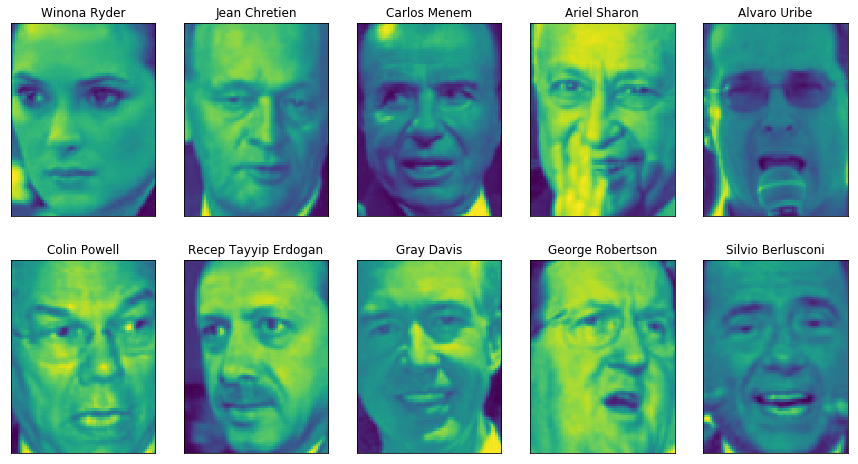

In [12]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

There are 3,023 images, each 87×65 pixels large, belonging to 62 different people.

In [13]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


The dataset is a bit skewed, however, containing a lot of images of George W. Bush and Colin Powell, as you can see here.

In [14]:
# Count how often each target appears
counts = np.bincount(people.target)

# Print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

To make the data less skewed, we will only take up to 50 images of each person (otherwise, the feature extraction would be overwhelmed by the likelihood of George W. Bush).

In [24]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# Scale the grayscale values to be between 0 and 1
# Instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

A common task in face recognition is to ask if a previously unseen face belongs to a known person from a database. This has applications in photo collection, social media, and security applications. 

One way to solve this problem would be to build a classifier where each person is a separate class. However, there are usually many different people in face databases, and very few images of the same person (i.e., very few training examples per class). That makes it hard to train most classifiers. Additionally, you often want to be able to add new people easily, without needing to retrain a large model.

A simple solution is to use a one-nearest-neighbor classifier that looks for the most similar face image to the face you are classifying. This classifier could in principle work with only a single training example per class. Let’s take a look at how well KNeighborsClassifier does here.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

# Build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


We obtain an accuracy of 23%, which is not actually that bad for a 62-class classification problem (random guessing would give you around 1/62 = 1.6% accuracy), but is also not great. We only correctly identify a person every fourth time.

This is where PCA comes in. Computing distances in the original pixel space is quite a bad way to measure similarity between faces. When using a pixel representation to compare two images, we compare the grayscale value of each individual pixel to the value of the pixel in the corresponding position in the other image. This representation is quite different from how humans would interpret the image of a face, and it is hard to capture the facial features using this raw representation. 

For example, using pixel distances means that shifting a face by one pixel to the right corresponds to a drastic change, with a completely different representation. We hope that using distances along principal components can improve our accuracy. Here, we enable the whitening option of PCA, which rescales the principal components to have the same scale. This is the same as using StandardScaler after the transformation. Reusing the data again, whitening corresponds to not only rotating the data, but also rescaling it so that the center panel is a circle instead of an ellipse.

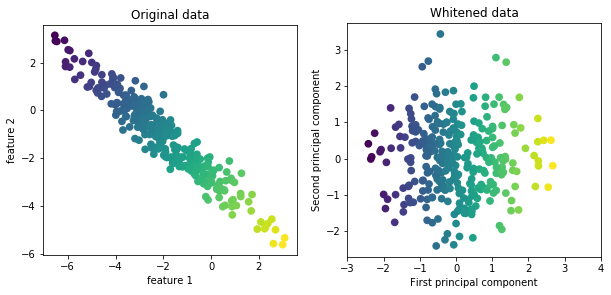

In [29]:
mglearn.plots.plot_pca_whitening()

We fit the *PCA* object to the training data and extract the first 100 principal components.  Then, we transform the training and test data.

In [30]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


The new data has 100 features, the first 100 principal components.  Now, we can use the new representation to classify our images using a one-nearest-neighbors classifier.

In [28]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


Our accuracy improved quite significantly, from 23% to 31%, confirming our intuition that the principal components might provide a better representation of the data.

For image data, we can also easily visualize the principal components that are found. Remember that components correspond to directions in the input space. The input space here is 87×65-pixel grayscale images, so directions within this space are also 87×65-pixel grayscale images.

Let’s look at the first couple of principal components.

In [31]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


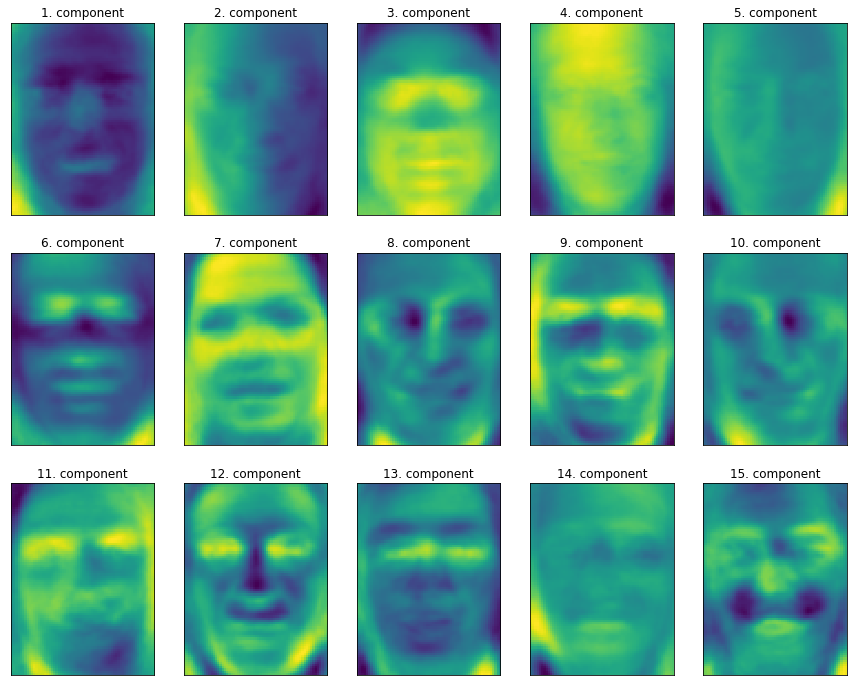

In [32]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

While we certainly cannot understand all aspects of these components, we can guess which aspects of the face images some of the components are capturing. The first component seems to mostly encode the contrast between the face and the background, the second component encodes differences in lighting between the right and the left half of the face, and so on. 

While this representation is slightly more semantic than the raw pixel values, it is still quite far from how a human might perceive a face. As the PCA model is based on pixels, the alignment of the face (the position of eyes, chin, and nose) and the lighting both have a strong influence on how similar two images are in their pixel representation. But alignment and lighting are probably not what a human would perceive first. When asking people to rate similarity of faces, they are more likely to use attributes like age, gender, facial expression, and hair style, which are attributes that are hard to infer from the pixel intensities. It’s important to keep in mind that algorithms often interpret data (particularly visual data, such as images, which humans are very familiar with) quite differently from how a human would.

Let’s come back to the specific case of PCA, though. We introduced the PCA transformation as rotating the data and then dropping the components with low variance. Another useful interpretation is to try to find some numbers (the new feature values after the PCA rotation) so that we can express the test points as a weighted sum of the principal components.

Here, x0, x1, and so on are the coefficients of the principal components for this data point; in other words, they are the representation of the image in the rotated space.

Another way we can try to understand what a PCA model is doing is by looking at the reconstructions of the original data using only some components. In Figure 3-3, after dropping the second component and arriving at the third panel, we undid the rotation and added the mean back to obtain new points in the original space with the second component removed, as shown in the last panel. We can do a similar transformation for the faces by reducing the data to only some principal components and then rotating back into the original space. This return to the original feature space can be done using the *inverse_transform* method. 

Here, we visualize the reconstruction of some faces using 10, 50, 100, or 500 components:

________________________________________________________________________________
[Memory] Calling mglearn.plot_pca.pca_faces...
pca_faces(array([[0.535948, ..., 0.243137],
       ...,
       [0.043137, ..., 0.596078]], dtype=float32), 
array([[0.237908, ..., 0.269281],
       ...,
       [0.4     , ..., 0.254902]], dtype=float32))
________________________________________________________pca_faces - 2.2s, 0.0min


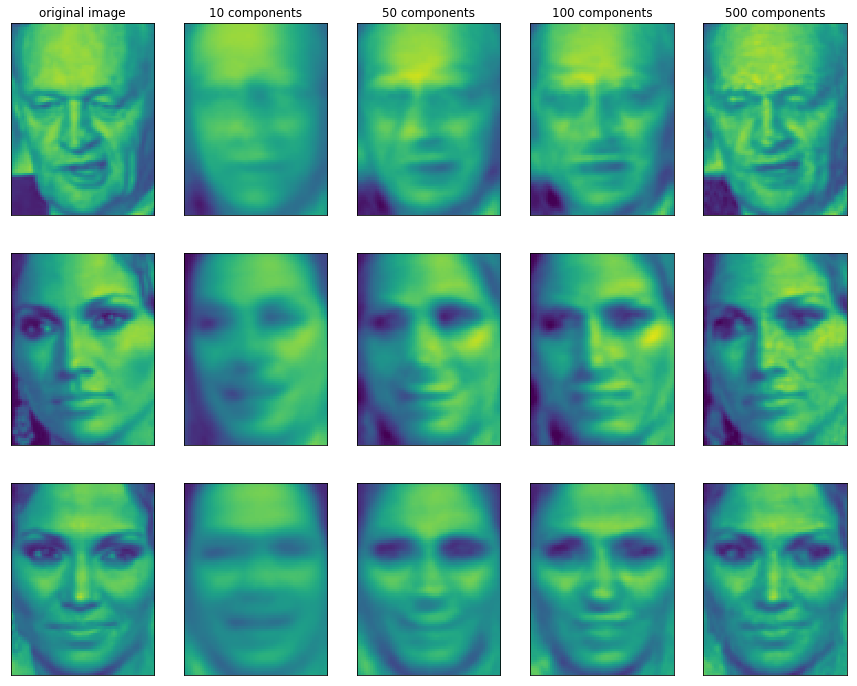

In [33]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

You can see that when we use only the first 10 principal components, only the essence of the picture, like the face orientation and lighting, is captured. By using more and more principal components, more and more details in the image are preserved. This corresponds to extending the sum in to include more and more terms. Using as many components as there are pixels would mean that we would not discard any information after the rotation, and we would reconstruct the image perfectly.

We can also try to use PCA to visualize all the faces in the dataset in a scatter plot using the first two principal components, with classes given by who is shown in the image, similarly to what we did for the cancer dataset:

Text(0, 0.5, 'Second principal component')

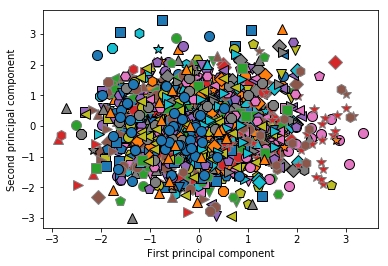

In [34]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)

plt.xlabel("First principal component")
plt.ylabel("Second principal component")

As you can see, when we use only the first two principal components the whole data is just a big blob, with no separation of classes visible. This is not very surprising, given that even with 10 components, PCA only captures very rough characteristics of the faces.